# Steel bar pull-out test on concrete

In [1]:
using Revise
using PyPlot
using Amaru

┌ Info: Recompiling stale cache file /home/raul/.julia/compiled/v1.0/Amaru/DPRo6.ji for Amaru [68281456-d7ce-5e5a-b7a0-5e8bda4b7efe]
└ @ Base loading.jl:1184


## Mesh generation

In [2]:
# Mesh generation

bls = [
       Block3D( [0 0 0; 1.0 6.0 1.0], nx=1, ny=10, nz=1),
       BlockInset( [0.5 3 0.5; 0.5 6.0 0.5], curvetype="polyline"),
      ]

msh = Mesh(bls, verbose=true)

# Tagging entities

bar_points  = sort(msh.cells[:lines][:points], by=get_y)
cell_points = msh.cells[:solids][:points]

tag!(bar_points[end], "tip")
tag!(cell_points, "fixed_points")


Mesh generation:
      2 blocks
  reordering points...                3d mesh                             
     55 points
     20 cells
     42 faces
     84 surface edges
      4 intersections
  done.


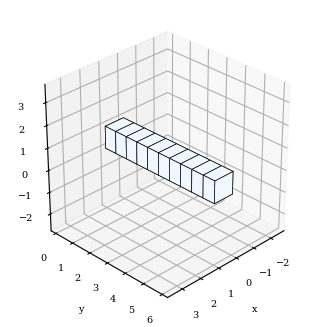

In [3]:
# Mesh plot

mplot(msh)

## Finite element analysis

In [4]:
# Constitutive models and material properties

phi = 30*pi/180; dm=0.15138; c=20.0
mats = [
        MaterialBind(:solids, ElasticSolid(E=24e3, nu=0.2)),
        MaterialBind(:lines, ElasticRod(E=1.e8, A=0.005)),
        MaterialBind(:lines, ElasticRod(E=200e6, A=0.00011)),
        MaterialBind(:joints1D, CEBJoint1D(TauM=12, TauR=3, s1=0.001, s2=0.0011, s3=0.004, alpha=0.5, beta=0.5,
                                           ks=(12/0.001)*5, kn=50000, A=0.005))
       ];

In [23]:
# Domain definition

dom = Domain(msh, mats);

log_tip     = Logger(:node, "tip")
log_jnt_ip  = Logger(first(dom.elems[:joints1d][:ips][:(y>5.8)]))
log_jnt_ips = IpGroupLogger(sort!(dom.elems[:joints1d][:ips], by=get_y))
logs = [ log_tip, log_jnt_ip, log_jnt_ips ]

setlogger!(dom, logs);

# Solving

bc1 = NodeBC("fixed_points", :(ux=0, uy=0, uz=0))
bc2 = NodeBC("tip", :(uy=+0.005))

solve!(dom, [bc1, bc2], nincs=40, autoinc=true, verbose=true)

Domain setup:
  3D domain general model      
     55 nodes
     20 elements
     42 faces
     84 edges
      4 materials
      0 loggers
  done.
FEM analysis:
  unknown dofs: 32
  increment 1 from t=0.0 to t=0.025 (dt=0.025):
    it 1   residue: 7.1487e-01
    it 2   residue: 4.8636e-02
    it 3   residue: 2.0247e-02
    it 4   residue: 8.9860e-03
  increment 2 from t=0.025 to t=0.05 (dt=0.025):
    it 1   residue: 2.2410e-01
    it 2   residue: 6.1509e-02
    it 3   residue: 2.2624e-02
    it 4   residue: 7.3659e-03
  increment 3 from t=0.05 to t=0.075 (dt=0.025):
    it 1   residue: 1.5223e-01
    it 2   residue: 3.9668e-02
    it 3   residue: 1.2280e-02
    it 4   residue: 3.5167e-03
  increment 4 from t=0.075 to t=0.1 (dt=0.025):
    it 1   residue: 1.2241e-01
    it 2   residue: 3.0074e-02
    it 3   residue: 8.3083e-03
  increment 5 from t=0.1 to t=0.125 (dt=0.025):
    it 1   residue: 1.0523e-01
    it 2   residue: 2.4584e-02
    it 3   residue: 6.2269e-03
  increment 6 from t

true

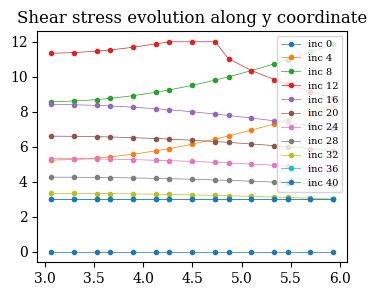

In [24]:
# Plotting

using PyPlot
rc("font", family="serif", size=10)

for i=0:4:40
    tab = log_jnt_ips.book.tables[i+1]
    plot(tab[:y], tab[:tau], marker="o", ms=3, label="inc $i")
end
legend();
title("Shear stress evolution along y coordinate");

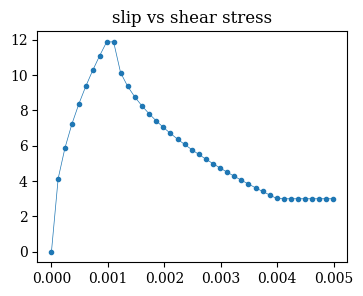

In [25]:
# Plotting

tab = log_jnt_ip.table
plot(tab[:ur], tab[:tau], marker="o", ms=3);
title("slip vs shear stress");

In [27]:
# Domain redefinition and solving

dom = Domain(msh, mats);

log_tip     = Logger(:node, "tip")
log_jnt_ip  = Logger(first(dom.elems[:joints1d][:ips][:(y>5.8)]))
log_jnt_ips = IpGroupLogger(sort!(dom.elems[:joints1d][:ips], by=get_y))
logs = [ log_tip, log_jnt_ip, log_jnt_ips ]
setlogger!(dom, logs);

# Solving
bc1 = NodeBC("fixed_points", :(ux=0, uy=0, uz=0))
bc2 = NodeBC("tip", :(uy=+0.0003))
solve!(dom, [bc1, bc2], nincs=10, autoinc=true, verbose=true)

bc2 = NodeBC("tip", :(uy=-0.0001))
solve!(dom, [bc1, bc2], nincs=10, autoinc=true, verbose=true)

bc2 = NodeBC("tip", :(uy=+0.0006))
solve!(dom, [bc1, bc2], nincs=10, autoinc=true, verbose=true)

bc2 = NodeBC("tip", :(uy=-0.0006))
solve!(dom, [bc1, bc2], nincs=10, autoinc=true, verbose=true)

bc2 = NodeBC("tip", :(uy=+0.005))
solve!(dom, [bc1, bc2], nincs=30, autoinc=true, verbose=true)


Domain setup:
  3D domain general model      
     55 nodes
     20 elements
     42 faces
     84 edges
      4 materials
      0 loggers
  done.
FEM analysis:
  unknown dofs: 32
  increment 1 from t=0.0 to t=0.1 (dt=0.1):
    it 1   residue: 8.2054e-02
    it 2   residue: 1.1611e-02
    it 3   residue: 5.2704e-03
  increment 2 from t=0.1 to t=0.2 (dt=0.1):
    it 1   residue: 1.0416e-01
    it 2   residue: 1.9369e-02
    it 3   residue: 1.2405e-02
    it 4   residue: 6.1357e-03
  increment 3 from t=0.2 to t=0.3 (dt=0.1):
    it 1   residue: 7.1108e-02
    it 2   residue: 1.7127e-02
    it 3   residue: 8.8647e-03
  increment 4 from t=0.3 to t=0.4 (dt=0.1):
    it 1   residue: 5.7350e-02
    it 2   residue: 1.5186e-02
    it 3   residue: 7.0046e-03
  increment 5 from t=0.4 to t=0.5 (dt=0.1):
    it 1   residue: 4.9409e-02
    it 2   residue: 1.3533e-02
    it 3   residue: 5.7585e-03
  increment 6 from t=0.5 to t=0.6 (dt=0.1):
    it 1   residue: 4.4093e-02
    it 2   residue: 1.2203e-0

    it 5   residue: 1.4010e-02
    increment failed.
  increment 10 from t=0.2831333333 to t=0.2956333333 (dt=0.0125):
    it 1   residue: 1.6554e-01
    it 2   residue: 7.7516e-03
  increment 11 from t=0.2956333333 to t=0.3144333333 (dt=0.0188):
    it 1   residue: 1.2192e+00
    it 2   residue: 8.4623e-02
    it 3   residue: 1.0034e-01
    it 4   residue: 3.3655e-02
    it 5   residue: 2.1456e-02
    increment failed.
  increment 11 from t=0.2956333333 to t=0.3050333333 (dt=0.0094):
    it 1   residue: 5.7424e-01
    it 2   residue: 6.0438e-02
    it 3   residue: 5.1325e-01
    it 4   residue: 6.9588e-02
    it 5   residue: 2.7129e+00
    increment failed.
  increment 11 from t=0.2956333333 to t=0.3003333333 (dt=0.0047):
    it 1   residue: 2.6793e-01
    it 2   residue: 4.4412e-02
    it 3   residue: 9.6682e-02
    it 4   residue: 2.9536e-02
    it 5   residue: 6.8948e-01
    increment failed.
  increment 11 from t=0.2956333333 to t=0.2979833333 (dt=0.00235):
    it 1   residue: 1.2

    it 2   residue: 3.9155e-02
    it 3   residue: 2.6883e-03
  increment 31 from t=0.3000678333 to t=0.3003078333 (dt=0.00024):
    it 1   residue: 1.7639e-02
    it 2   residue: 4.3564e-02
    it 3   residue: 4.0297e-03
  increment 32 from t=0.3003078333 to t=0.3006678333 (dt=0.00036):
    it 1   residue: 2.5298e-02
    it 2   residue: 5.2688e-02
    it 3   residue: 2.1908e-01
    increment failed.
  increment 32 from t=0.3003078333 to t=0.3004878333 (dt=0.00018):
    it 1   residue: 1.1752e-02
    it 2   residue: 3.5854e-02
    it 3   residue: 3.0226e-03
  increment 33 from t=0.3004878333 to t=0.3007578333 (dt=0.00027):
    it 1   residue: 1.7272e-02
    it 2   residue: 3.9795e-02
    it 3   residue: 4.5313e-03
  increment 34 from t=0.3007578333 to t=0.3011628333 (dt=0.000405):
    it 1   residue: 2.4872e-02
    it 2   residue: 5.7491e-02
    it 3   residue: 8.2164e-01
    increment failed.
  increment 34 from t=0.3007578333 to t=0.3009598333 (dt=0.000202):
    it 1   residue: 1.153

    it 1   residue: 8.5126e-02
    it 2   residue: 1.3392e-02
    it 3   residue: 9.8882e-02
    it 4   residue: 1.3431e-02
    it 5   residue: 9.8907e-02
    increment failed.
  increment 55 from t=0.3088918333 to t=0.3093848333 (dt=0.000493):
    it 1   residue: 4.2563e-02
    it 2   residue: 6.6972e-03
  increment 56 from t=0.3093848333 to t=0.3101238333 (dt=0.000739):
    it 1   residue: 7.6711e-02
    it 2   residue: 1.0062e-02
    it 3   residue: 7.8737e-02
    it 4   residue: 1.0073e-02
    it 5   residue: 7.8737e-02
    increment failed.
  increment 56 from t=0.3093848333 to t=0.3097548333 (dt=0.00037):
    it 1   residue: 3.8407e-02
    it 2   residue: 5.0382e-03
  increment 57 from t=0.3097548333 to t=0.3103098333 (dt=0.000555):
    it 1   residue: 6.4346e-02
    it 2   residue: 8.1847e-03
  increment 58 from t=0.3103098333 to t=0.3111428333 (dt=0.000833):
    it 1   residue: 1.0979e-01
    it 2   residue: 1.2267e-02
    it 3   residue: 1.1094e-01
    it 4   residue: 1.2261e-

    it 2   residue: 1.0151e-02
    it 3   residue: 3.6634e-01
    it 4   residue: 1.0150e-02
    it 5   residue: 3.6634e-01
    increment failed.
  increment 79 from t=0.3192208333 to t=0.3194738333 (dt=0.000253):
    it 1   residue: 1.7864e-01
    it 2   residue: 5.0656e-03
  increment 80 from t=0.3194738333 to t=0.3198538333 (dt=0.00038):
    it 1   residue: 2.8783e-01
    it 2   residue: 7.6056e-03
  increment 81 from t=0.3198538333 to t=0.3204238333 (dt=0.00057):
    it 1   residue: 4.8355e-01
    it 2   residue: 1.1401e-02
    it 3   residue: 5.1922e-01
    it 4   residue: 1.1396e-02
    it 5   residue: 5.1922e-01
    increment failed.
  increment 81 from t=0.3198538333 to t=0.3201388333 (dt=0.000285):
    it 1   residue: 2.4178e-01
    it 2   residue: 5.7007e-03
  increment 82 from t=0.3201388333 to t=0.3205668333 (dt=0.000428):
    it 1   residue: 3.9818e-01
    it 2   residue: 8.5562e-03
  increment 83 from t=0.3205668333 to t=0.3212088333 (dt=0.000642):
    it 1   residue: 6.9

    it 2   residue: 2.5203e-01
    it 3   residue: 1.0550e-02
    it 4   residue: 8.1557e-02
    increment failed.
  increment 103 from t=0.3274768333 to t=0.3277408333 (dt=0.000264):
    it 1   residue: 4.9492e-02
    it 2   residue: 2.3013e-01
    it 3   residue: 5.2719e-03
  increment 104 from t=0.3277408333 to t=0.3281368333 (dt=0.000396):
    it 1   residue: 7.2518e-02
    it 2   residue: 2.3861e-01
    it 3   residue: 7.9215e-03
  increment 105 from t=0.3281368333 to t=0.3287308333 (dt=0.000594):
    it 1   residue: 1.0376e-01
    it 2   residue: 2.4177e-01
    it 3   residue: 1.1897e-02
    it 4   residue: 7.9458e-02
    increment failed.
  increment 105 from t=0.3281368333 to t=0.3284338333 (dt=0.000297):
    it 1   residue: 4.7974e-02
    it 2   residue: 2.1999e-01
    it 3   residue: 5.9359e-03
  increment 106 from t=0.3284338333 to t=0.3288798333 (dt=0.000446):
    it 1   residue: 7.0518e-02
    it 2   residue: 2.2843e-01
    it 3   residue: 8.9268e-03
  increment 107 from t

    it 1   residue: 3.2508e-02
    it 2   residue: 1.2476e-01
    it 3   residue: 9.0293e-03
  increment 128 from t=0.3368108333 to t=0.3376248333 (dt=0.000814):
    it 1   residue: 4.8390e-02
    it 2   residue: 1.3273e-01
    it 3   residue: 1.3527e-02
    it 4   residue: 3.9091e-02
    increment failed.
  increment 128 from t=0.3368108333 to t=0.3372178333 (dt=0.000407):
    it 1   residue: 2.2824e-02
    it 2   residue: 1.0695e-01
    it 3   residue: 6.7687e-03
  increment 129 from t=0.3372178333 to t=0.3378278333 (dt=0.00061):
    it 1   residue: 3.4210e-02
    it 2   residue: 1.1962e-01
    it 3   residue: 1.0139e-02
    it 4   residue: 2.8164e-02
    increment failed.
  increment 129 from t=0.3372178333 to t=0.3375228333 (dt=0.000305):
    it 1   residue: 1.6288e-02
    it 2   residue: 8.9855e-02
    it 3   residue: 5.0731e-03
  increment 130 from t=0.3375228333 to t=0.3379808333 (dt=0.000458):
    it 1   residue: 2.4547e-02
    it 2   residue: 1.0533e-01
    it 3   residue: 7.6

    it 3   residue: 9.9324e-03
  increment 151 from t=0.3473328333 to t=0.3484428333 (dt=0.00111):
    it 1   residue: 3.6447e-02
    it 2   residue: 6.1378e-02
    it 3   residue: 1.6070e-02
    it 4   residue: 2.7836e-02
    increment failed.
  increment 151 from t=0.3473328333 to t=0.3478878333 (dt=0.000555):
    it 1   residue: 1.7385e-02
    it 2   residue: 4.8377e-02
    it 3   residue: 8.1103e-03
  increment 152 from t=0.3478878333 to t=0.3487208333 (dt=0.000833):
    it 1   residue: 2.6112e-02
    it 2   residue: 5.4576e-02
    it 3   residue: 1.1135e-02
    it 4   residue: 2.0715e-02
    increment failed.
  increment 152 from t=0.3478878333 to t=0.3483038333 (dt=0.000416):
    it 1   residue: 1.2549e-02
    it 2   residue: 3.9107e-02
    it 3   residue: 6.0757e-03
  increment 153 from t=0.3483038333 to t=0.3489278333 (dt=0.000624):
    it 1   residue: 1.8872e-02
    it 2   residue: 4.6886e-02
    it 3   residue: 8.3514e-03
  increment 154 from t=0.3489278333 to t=0.3498638333 

    it 2   residue: 8.6709e-03
  increment 180 from t=0.5367558333 to t=0.5700558333 (dt=0.0333):
    it 1   residue: 5.5558e-02
    it 2   residue: 7.1530e-03
  increment 181 from t=0.5700558333 to t=0.6033558333 (dt=0.0333):
    it 1   residue: 5.0332e-02
    it 2   residue: 6.0747e-03
  increment 182 from t=0.6033558333 to t=0.6366558333 (dt=0.0333):
    it 1   residue: 4.6282e-02
    it 2   residue: 5.2714e-03
  increment 183 from t=0.6366558333 to t=0.6699558333 (dt=0.0333):
    it 1   residue: 4.3032e-02
    it 2   residue: 4.6510e-03
  increment 184 from t=0.6699558333 to t=0.7032558333 (dt=0.0333):
    it 1   residue: 4.0355e-02
    it 2   residue: 4.1617e-03
  increment 185 from t=0.7032558333 to t=0.7365558333 (dt=0.0333):
    it 1   residue: 3.8087e-02
    it 2   residue: 3.7565e-03
  increment 186 from t=0.7365558333 to t=0.7698558333 (dt=0.0333):
    it 1   residue: 3.6052e-02
    it 2   residue: 3.3565e-03
  increment 187 from t=0.7698558333 to t=0.8031558333 (dt=0.0333):

true

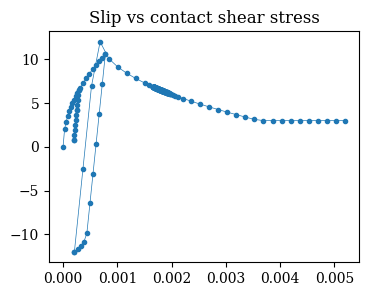

PyObject Text(0.5,1,'Slip vs contact shear stress')

In [29]:
# Plotting

tab = log_jnt_ip.table
plot(tab[:ur], tab[:tau], marker="o", ms=3);
title("Slip vs contact shear stress")